# Person Re-identification

| Contribution   |
| :---   |
| Leonardo Villamil  |
| Litian Chen        | 

In [2]:
import os
import cv2
import numpy as np
import scipy.io
import pandas as pd
import glob
import random

import visualkeras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import discriminant_analysis
from sklearn import datasets

tf.keras.backend.clear_session()

### Functions

In [3]:
def plot_eval_model(history, model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2);
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    fig = plt.figure(figsize=[12, 4])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();
        
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)

    cm = confusion_matrix(y_test, indexes, normalize='true')
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    x = layers.Conv2D(filters=filters, kernel_size=(5,5), padding='valid', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(5,5), padding='valid', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

def GetSiameseData(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def GetTripletData(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

def TripleGenerator(imgs, labels, batch_size):
    while True:
        [image_a, image_b, image_c] = GetTripletData(imgs, labels, batch_size)
        yield [image_a, image_b, image_c], None

## Load Data

In [4]:
#Load images from data files
training_Img = []
gallery_Img = []
probe_Img = []

for img in glob.glob("Data/Q2/Training/*.jpg"):
    # 0 indected using grayscale for cv2.imread
    I = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    training_Img.append(I)

for img in glob.glob("Data/Q2/Testing/Gallery/*.jpg"):
    # 0 indected using grayscale for cv2.imread
    I = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    gallery_Img.append(I)

for img in glob.glob("Data/Q2/Testing/Probe/*.jpg"):
    # 0 indected using grayscale for cv2.imread
    I = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    probe_Img.append(I)

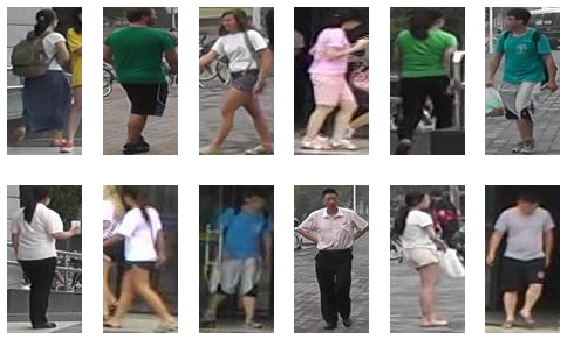

In [5]:
#visualise some of the training images 
fig = plt.figure(figsize=[10, 6])
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    ax.imshow(training_Img[i])
    ax.set_axis_off()

In [6]:
# Read the image label them using the first four digits as each person's ID

training_ID =[]
gallery_ID = []
probe_ID = []

training_ID = os.listdir('Data/Q2/Training')
for i in range(len(training_ID)):
    temp = training_ID[i]
    temp = int(temp[0:4])
    training_ID[i] = temp

gallery_ID = os.listdir('Data/Q2/Testing/Gallery')
for i in range(len(gallery_ID)):
    temp = gallery_ID[i]
    temp = int(temp[0:4])
    gallery_ID[i] = temp

probe_ID = os.listdir('Data/Q2/Testing/Probe')
for i in range(len(probe_ID)):
    temp = probe_ID[i]
    temp = int(temp[0:4])
    probe_ID[i] = temp

In [7]:
training_Img = np.array(training_Img).astype('float32')/255
gallery_Img = np.array(gallery_Img).astype('float32')/255
probe_Img = np.array(probe_Img).astype('float32')/255

training_ID = np.array(training_ID)
gallery_ID = np.array(gallery_ID)
probe_ID = np.array(probe_ID)

## PCA

In [8]:
# Reshape data into a 1D vector
training_1D = np.reshape(training_Img,(len(training_Img),-1))
gallery_1D = np.reshape(gallery_Img,(len(gallery_Img),-1))
probe_1D = np.reshape(probe_Img,(len(probe_Img),-1))

In [9]:
pca = decomposition.PCA()
pca.fit(training_1D)

training_transformed = pca.transform(training_1D)
gallery_transformed = pca.transform(gallery_1D)
probe_transformed = pca.transform(probe_1D)

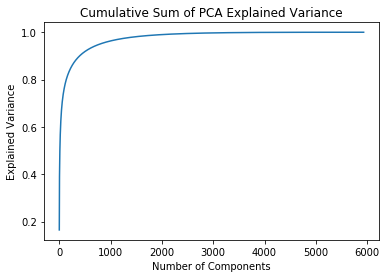

In [10]:
# Explained components curve
cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
fig = plt.figure(figsize=[6, 4])
ax = fig.add_subplot(1, 1, 1)
ax.plot(cumulative_sum)
ax.set_title('Cumulative Sum of PCA Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Components');

In [11]:
# Read the number of components for 90%, 95% and 99%
top90 = np.where(cumulative_sum > 0.90)[0][0]
print('90% in ' + '%d' % (top90+1) + ' components')
top95 = np.where(cumulative_sum > 0.95)[0][0]
print('95% in ' + '%d' % (top95+1) + ' components')
top99 = np.where(cumulative_sum > 0.99)[0][0]
print('99% in ' + '%d' % (top99+1) + ' components')

90% in 397 components
95% in 791 components
99% in 1993 components


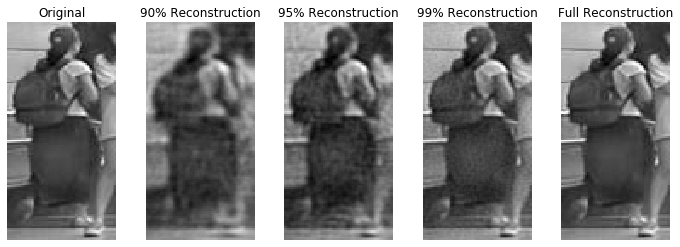

In [12]:
fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(1, 5, 1)
I = np.reshape(training_1D[0,:] - pca.mean_, (128, 64, 3))
ax.imshow(I[:,:,0], cmap=plt.get_cmap('gray'))
ax.set_title('Original')
ax.set_axis_off();

ax = fig.add_subplot(1, 5, 2)
I = np.reshape(pca.components_[0:top90,:].transpose().dot(np.reshape(training_transformed[0,0:top90], (-1, 1))), (128, 64,3))
ax.imshow(I[:,:,0], cmap=plt.get_cmap('gray'))
ax.set_title('90% Reconstruction')
ax.set_axis_off();

ax = fig.add_subplot(1, 5, 3)
I = np.reshape(pca.components_[0:top95,:].transpose().dot(np.reshape(training_transformed[0,0:top95], (-1, 1))), (128, 64, 3))
ax.imshow(I[:,:,0], cmap=plt.get_cmap('gray'))
ax.set_title('95% Reconstruction')
ax.set_axis_off();

ax = fig.add_subplot(1, 5, 4)
I = np.reshape(pca.components_[0:top99,:].transpose().dot(np.reshape(training_transformed[0,0:top99], (-1, 1))), (128, 64, 3))
ax.imshow(I[:,:,0], cmap=plt.get_cmap('gray'))
ax.set_title('99% Reconstruction')
ax.set_axis_off();

ax = fig.add_subplot(1, 5, 5)
I = np.reshape(pca.components_[:,:].transpose().dot(np.reshape(training_transformed[0,:], (-1, 1))), (128, 64, 3))
ax.imshow(I[:,:,0], cmap=plt.get_cmap('gray'))
ax.set_title('Full Reconstruction')
ax.set_axis_off();

Let's reduce the data by keeping 95% of the variance

In [13]:
# Top 95% of the variance
training_transformed_95 = training_transformed[:, 0:top95]
gallery_transformed_95 = gallery_transformed[:, 0:top95]
probe_transformed_95 = probe_transformed[:, 0:top95]

## Matching and Ranking - PCA Feature Vector

In [14]:
# storage for ranked histogram
ranked_histogram = np.zeros(len(np.unique(probe_ID)))

# loop over all IDs in the probe set
for i in range(len(probe_transformed_95)):
    # get the true ID of this sample
    true_ID = probe_ID[i]
    if i == 0:
        print('Searching for first ID: %d\n' % (true_ID))

    # Get the distance between the current probe and the whole gallery
    # Using Euclidean distance
    dist = np.zeros(len(gallery_transformed_95))
    for j in range(len(gallery_transformed_95)):
        dist[j] = np.linalg.norm(probe_transformed_95[i] - gallery_transformed_95[j])
    if i == 0:
        print('Distance between first source feature and all target features:')
        print(dist)
    
    # Get the sorted order of the distances
    a = np.argsort(dist)
    # Apply the order to the gallery IDs
    ranked = gallery_ID[a]
    if i == 0:
        print('\nRanked IDs for first query:')
        print(ranked)

    # Find the location of the True Match in the ranked list
    ranked_result = np.where(ranked == true_ID)[0][0]
    if i == 0:
        print('\nLocation of the True Match for first query:')
        print(ranked_result)

    # Store the ranking result in the histogram
    ranked_histogram[ranked_result] += 1

print('\nRanking result:')    
print(ranked_histogram)

Searching for first ID: 1463

Distance between first source feature and all target features:
[52.86981583 35.45333099 41.7259407  33.95776749 32.27815247 39.23254395
 29.16077423 53.29570389 46.15932846 38.38959503 35.25394821 50.46023941
 46.71829605 34.44506073 30.012537   37.93559647 36.68286896 41.62503815
 37.96519852 46.87864685 33.6016655  45.52011871 34.91743851 33.92048645
 38.20344162 41.45098114 43.5376358  43.43981552 36.0398407  38.51728058
 51.39831161 50.10520172 34.9848671  37.18741226 34.52308655 38.16254044
 31.23578453 45.77669525 39.70896149 40.34407806 45.1270752  38.8947525
 32.92336655 30.59022522 40.7383728  35.26831436 41.24108124 33.89944839
 33.09108734 50.77113724 31.11992836 48.15137863 42.16753769 33.10155487
 32.94999695 34.90549469 40.22663116 30.01828957 33.50827789 36.81489563
 33.28509903 32.90153122 42.56083679 42.98552704 44.8572998  30.94816971
 49.7876358  37.52360535 28.41746521 29.76497078 31.37635803 35.80973053
 26.32959557 31.75710678 39.7374

### CMC Curve

[ 29.  36.  42.  49.  52.  60.  64.  69.  70.  75.  77.  82.  87.  91.
  95. 101. 103. 103. 104. 108. 112. 114. 115. 119. 119. 122. 123. 126.
 127. 129. 130. 130. 138. 139. 140. 142. 143. 143. 144. 146. 149. 149.
 154. 155. 156. 156. 156. 158. 159. 159. 159. 162. 165. 166. 168. 169.
 170. 170. 172. 172. 172. 172. 172. 173. 173. 174. 175. 176. 176. 178.
 178. 178. 182. 182. 184. 185. 185. 185. 186. 186. 186. 186. 188. 189.
 190. 192. 193. 193. 195. 197. 199. 200. 201. 201. 202. 202. 204. 205.
 206. 206. 208. 208. 211. 212. 213. 214. 214. 214. 215. 216. 216. 216.
 216. 216. 218. 219. 219. 220. 220. 220. 220. 220. 220. 220. 222. 222.
 222. 222. 222. 222. 223. 224. 225. 226. 226. 227. 228. 228. 231. 232.
 232. 232. 233. 234. 234. 234. 235. 237. 239. 240. 240. 240. 240. 240.
 240. 241. 242. 242. 242. 242. 242. 245. 246. 246. 247. 247. 248. 248.
 249. 250. 252. 253. 253. 254. 254. 255. 255. 255. 255. 255. 256. 256.
 256. 257. 258. 258. 258. 258. 260. 260. 260. 261. 263. 264. 264. 264.
 264. 

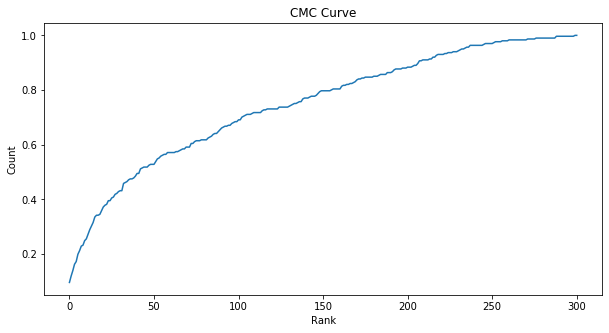

In [15]:
cmc = np.zeros(len(np.unique(probe_ID)))
for i in range(len(np.unique(probe_ID))):
    cmc[i] = np.sum(ranked_histogram[:(i + 1)])
    
print(cmc)

fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(1, 1, 1)
ax.plot(cmc/len(np.unique(probe_ID)))
ax.set_xlabel('Rank')
ax.set_ylabel('Count')
ax.set_title('CMC Curve');

In [16]:
# Final Results
rank_accuracy = cmc/len(np.unique(probe_ID))
print('Accuracy for Rank-1  retrieval: %f%%' % (rank_accuracy[0]*100))
print('Accuracy for Rank-5  retrieval: %f%%' % (rank_accuracy[4]*100))
print('Accuracy for Rank-10 retrieval: %f%%' % (rank_accuracy[9]*100))

Accuracy for Rank-1  retrieval: 9.634551%
Accuracy for Rank-5  retrieval: 17.275748%
Accuracy for Rank-10 retrieval: 24.916944%


## Matching and Ranking - PCA + LDA Feature Vector

In [17]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(training_transformed_95, training_ID)
training_transformed_lda = lda.transform(training_transformed_95)
gallery_transformed_lda = lda.transform(gallery_transformed_95)
probe_transformed_lda = lda.transform(probe_transformed_95)

print('Dimentions training after LDA: %s' %(np.shape(training_transformed_lda),))

Dimentions training after LDA: (5933, 299)


In [18]:
# storage for ranked histogram
ranked_histogram = np.zeros(len(np.unique(probe_ID)))

# loop over all IDs in the probe set
for i in range(len(probe_transformed_lda)):
    # get the true ID of this sample
    true_ID = probe_ID[i]
    if i == 0:
        print('Searching for first ID: %d\n' % (true_ID))

    # Get the distance between the current probe and the whole gallery.
    # Using Euclidean distance
    dist = np.zeros(len(gallery_transformed_lda))
    for j in range(len(gallery_transformed_lda)):
        dist[j] = np.linalg.norm(probe_transformed_lda[i] - gallery_transformed_lda[j])
    if i == 0:
        print('Distance between first source feature and all target features:')
        print(dist)
    
    # Get the sorted order of the distances
    a = np.argsort(dist)
    # Apply the order to the gallery IDs
    ranked = gallery_ID[a]
    if i == 0:
        print('\nRanked IDs for first query:')
        print(ranked)

    # Find the location of the True Match in the ranked list
    ranked_result = np.where(ranked == true_ID)[0][0]
    if i == 0:
        print('\nLocation of the True Match for first query:')
        print(ranked_result)

    # Store the ranking result in the histogram
    ranked_histogram[ranked_result] += 1

print('\nRanking result:')    
print(ranked_histogram)

Searching for first ID: 1463

Distance between first source feature and all target features:
[23.5795462  23.43869042 24.11097846 20.71220029 24.98557647 22.05314823
 22.78444066 22.22030461 21.67104951 26.53894146 23.08714981 25.20015912
 32.37067128 23.51019241 24.40507568 22.76889785 23.84798808 26.30865718
 30.12108587 19.90631772 22.97185914 29.82645537 23.83599561 21.78287634
 23.28348158 26.75376872 22.62534152 28.05987892 23.94738119 25.20875897
 22.96133221 25.2886305  24.9383172  23.58219639 21.82128097 23.02009724
 24.54845633 24.02748153 26.6072198  23.89428197 28.90557938 24.48778019
 20.47458158 24.37568298 26.5411919  21.81823058 23.16313114 20.83396458
 25.4748163  23.31921178 24.58715974 22.95321064 25.34219657 24.37369499
 23.28705815 22.51812094 24.65831201 20.20422378 24.0768041  24.56613936
 26.86469499 22.68355343 26.76766091 24.70743135 23.39511509 24.26971704
 26.68694122 26.51251261 24.9957261  23.41791687 21.63631334 22.88381883
 23.3970109  26.65314997 24.411

### CMC Curve

[ 22.  29.  35.  39.  42.  47.  51.  56.  58.  58.  61.  64.  70.  74.
  79.  81.  83.  87.  89.  91.  94.  96.  98. 103. 104. 105. 106. 106.
 108. 111. 112. 115. 118. 120. 121. 123. 125. 126. 128. 129. 133. 134.
 134. 134. 135. 136. 138. 139. 140. 141. 141. 142. 143. 146. 146. 147.
 149. 151. 152. 154. 156. 157. 157. 158. 159. 163. 164. 166. 166. 167.
 167. 168. 172. 172. 172. 172. 174. 174. 175. 176. 178. 178. 178. 180.
 181. 181. 182. 184. 185. 186. 188. 188. 188. 188. 189. 189. 190. 191.
 192. 192. 192. 192. 193. 194. 195. 196. 196. 198. 201. 201. 203. 203.
 205. 205. 205. 206. 206. 206. 207. 208. 208. 210. 210. 211. 211. 212.
 214. 215. 216. 216. 216. 217. 218. 220. 221. 222. 223. 224. 224. 227.
 227. 227. 229. 230. 230. 231. 231. 231. 232. 232. 233. 233. 234. 234.
 235. 235. 236. 237. 237. 237. 237. 239. 239. 239. 240. 241. 241. 241.
 243. 244. 245. 245. 245. 245. 245. 246. 246. 249. 249. 249. 250. 252.
 253. 253. 253. 253. 254. 255. 255. 255. 255. 256. 257. 257. 257. 257.
 257. 

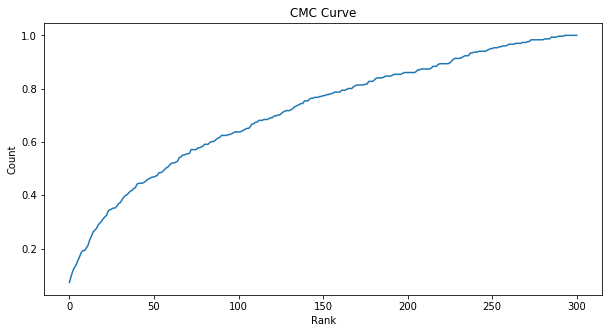

In [19]:
cmc = np.zeros(len(np.unique(probe_ID)))
for i in range(len(np.unique(probe_ID))):
    cmc[i] = np.sum(ranked_histogram[:(i + 1)])
    
print(cmc)

fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(1, 1, 1)
ax.plot(cmc/len(np.unique(probe_ID)))
ax.set_xlabel('Rank')
ax.set_ylabel('Count')
ax.set_title('CMC Curve');

In [20]:
# Final Results
rank_accuracy = cmc/len(np.unique(probe_ID))
print('Accuracy for Rank-1  retrieval: %f%%' % (rank_accuracy[0]*100))
print('Accuracy for Rank-5  retrieval: %f%%' % (rank_accuracy[4]*100))
print('Accuracy for Rank-10 retrieval: %f%%' % (rank_accuracy[9]*100))

Accuracy for Rank-1  retrieval: 7.308970%
Accuracy for Rank-5  retrieval: 13.953488%
Accuracy for Rank-10 retrieval: 19.269103%


## Siamese Networks

### Data Generation

In [21]:
X_train, X_validation, y_train, y_validation = train_test_split(training_Img, training_ID, test_size=0.2)

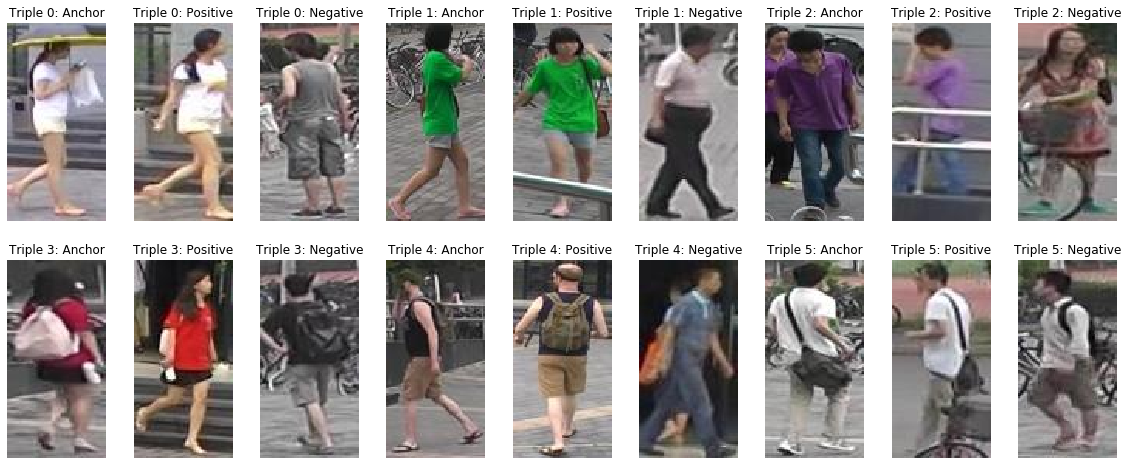

In [22]:
test = TripleGenerator(X_train, y_train, 6)
x, _ = next(test)

fig = plt.figure(figsize=[20, 8])
for i in range(6):
    ax = fig.add_subplot(2, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,:])
    ax.set_title('Triple ' + str(i) + ': Anchor')
    ax.set_axis_off()
    
    ax = fig.add_subplot(2, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,:])    
    ax.set_title('Triple ' + str(i) + ': Positive')
    ax.set_axis_off()

    ax = fig.add_subplot(2, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,:])    
    ax.set_title('Triple ' + str(i) + ': Negative')
    ax.set_axis_off()

Let's create our base network according to a VGG Net

In [23]:
embedding_size = 128
dummy_input = keras.Input((128, 64, 3))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')
base_network.summary()

Model: "SiameseBranch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 64, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 124, 60, 8)        608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 56, 8)        1608      
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 56, 8)        32        
_________________________________________________________________
activation (Activation)      (None, 120, 56, 8)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 120, 56, 8)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 28, 8)       

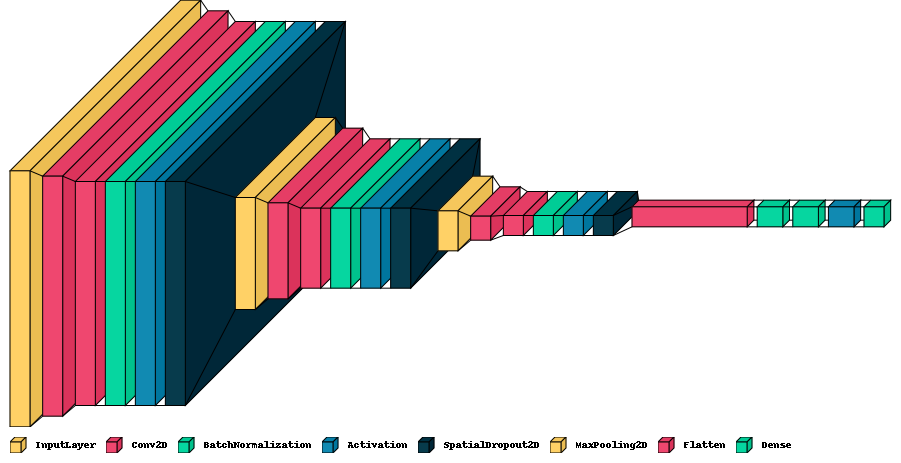

In [24]:
visualkeras.layered_view(base_network, legend=True)

In [25]:
class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = K.l2_normalize(anchor, axis=1)
        positive = K.l2_normalize(positive, axis=1)
        negative = K.l2_normalize(negative, axis=1)

        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [26]:
input_anchor = keras.Input((128, 64, 3), name='Anchor')
input_positive = keras.Input((128, 64, 3), name='Positive')
input_negative = keras.Input((128, 64, 3), name='Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')([embedding_anchor, embedding_positive, embedding_negative])

In [27]:
triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)
triplet_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor (InputLayer)             [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
Positive (InputLayer)           [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
Negative (InputLayer)           [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
SiameseBranch (Functional)      (None, 128)          379624      Anchor[0][0]                     
                                                                 Positive[0][0]               

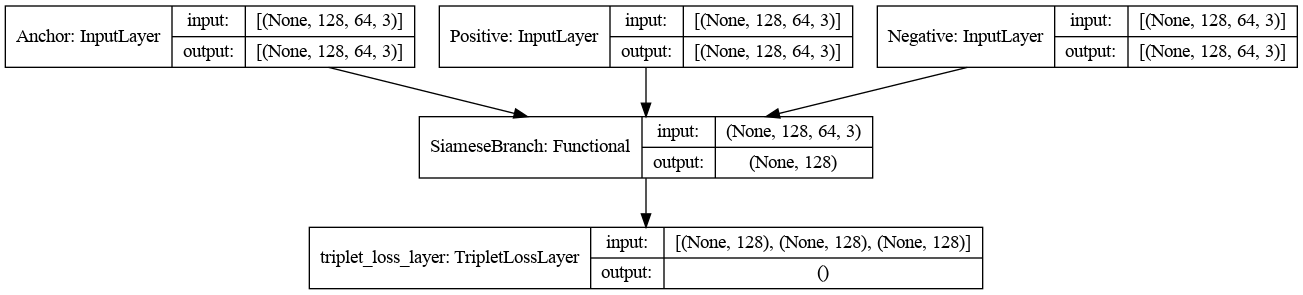

In [28]:
keras.utils.plot_model(triplet_network, show_shapes=True)

In [29]:
triplet_network.compile(optimizer=keras.optimizers.RMSprop())

batch_size = 128
training_gen = TripleGenerator(X_train, y_train, batch_size)
triplet_validation_x = GetTripletData(X_validation, y_validation, 1000)

triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=10, validation_data=(triplet_validation_x, None))

Epoch 1/10
468/468 [==============================] - 1047s 2s/step - loss: 42.5857 - val_loss: 4.3094
Epoch 2/10
468/468 [==============================] - 1091s 2s/step - loss: 21.1069 - val_loss: 4.2273
Epoch 3/10
468/468 [==============================] - 1024s 2s/step - loss: 16.9248 - val_loss: 3.2587
Epoch 4/10
468/468 [==============================] - 1026s 2s/step - loss: 14.9201 - val_loss: 2.9288
Epoch 5/10
468/468 [==============================] - 1033s 2s/step - loss: 13.2040 - val_loss: 2.8140
Epoch 6/10
468/468 [==============================] - 1034s 2s/step - loss: 11.5407 - val_loss: 3.2603
Epoch 7/10
468/468 [==============================] - 1032s 2s/step - loss: 10.7949 - val_loss: 3.7433
Epoch 8/10
468/468 [==============================] - 1032s 2s/step - loss: 10.3871 - val_loss: 2.6888
Epoch 9/10
468/468 [==============================] - 1032s 2s/step - loss: 9.8156 - val_loss: 2.7428
Epoch 10/10
468/468 [==============================] - 1039s 2s/step - los

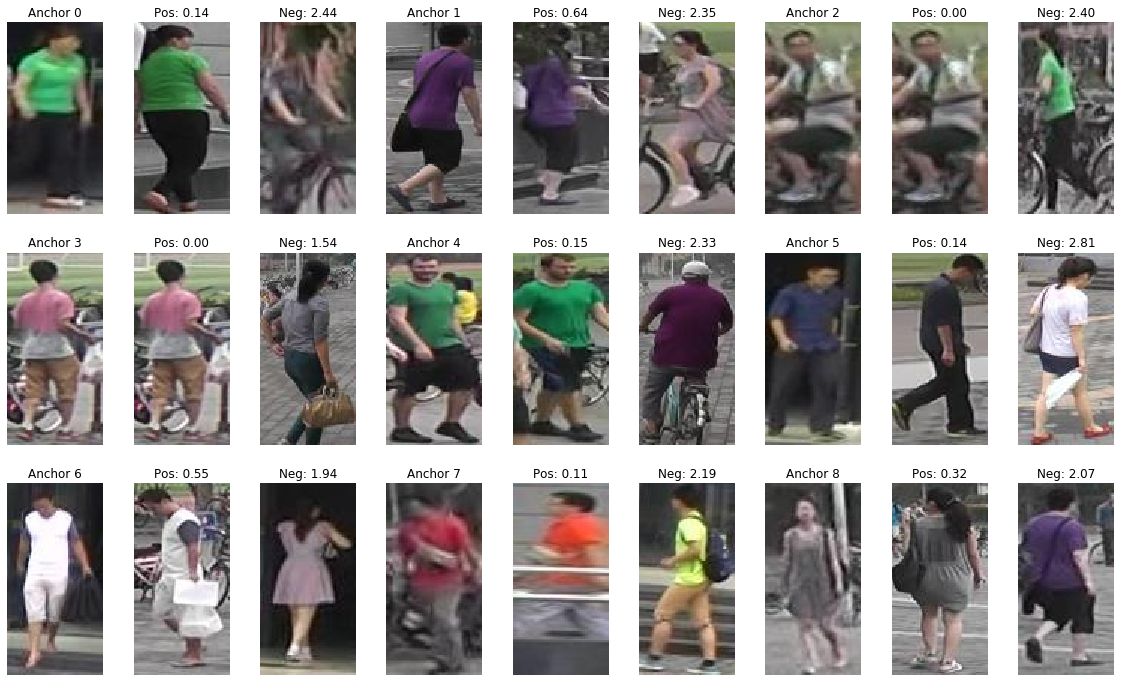

In [32]:
def ComputeDistance(x, y):
    x = K.l2_normalize(x, axis=1)
    y = K.l2_normalize(y, axis=1)
    dist = K.sum(K.square(x - y), axis=-1)
    return dist

x = GetTripletData(X_validation, y_validation, 9)
anchor_embedding = base_network.predict(x[0])
positive_embedding = base_network.predict(x[1])
negative_embedding = base_network.predict(x[2])
pos_dists = ComputeDistance(anchor_embedding, positive_embedding)
neg_dists = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[20, 12])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,:])
    ax.set_title('Anchor ' + str(i))
    ax.set_axis_off()
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,:])    
    ax.set_title('Pos: ' + '%1.2f' % float(pos_dists[i]))
    ax.set_axis_off()
    
    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,:])    
    ax.set_title('Neg: ' + '%1.2f' % float(neg_dists[i]))
    ax.set_axis_off()

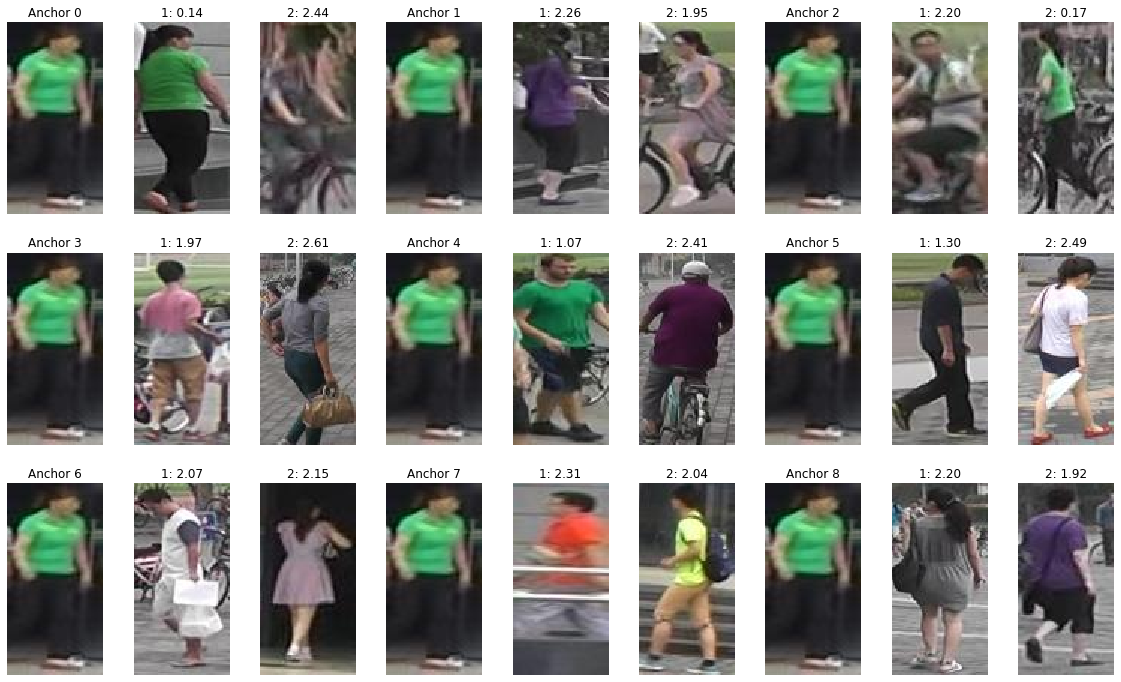

In [33]:
for i in range(9):
    x[0][i,:] = x[0][0,:]

anchor_embedding = base_network.predict(x[0])
positive_embedding = base_network.predict(x[1])
negative_embedding = base_network.predict(x[2])
pos_dists = ComputeDistance(anchor_embedding, positive_embedding)
neg_dists = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[20, 12])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,:])
    ax.set_title('Anchor ' + str(i))
    ax.set_axis_off()
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,:])    
    ax.set_title('1: ' + '%1.2f' % float(pos_dists[i]))
    ax.set_axis_off()
    
    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,:])    
    ax.set_title('2: ' + '%1.2f' % float(neg_dists[i]))
    ax.set_axis_off()

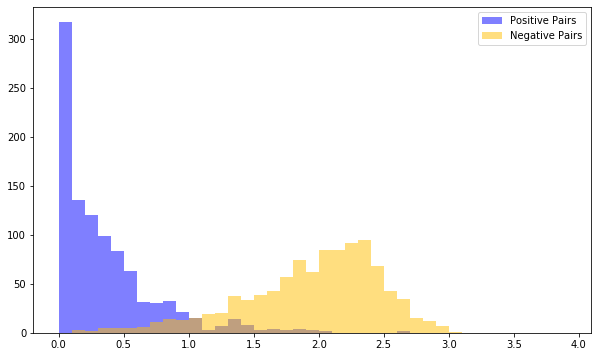

In [36]:
anchor_embedding = base_network.predict(triplet_validation_x[0])
positive_embedding = base_network.predict(triplet_validation_x[1])
negative_embedding = base_network.predict(triplet_validation_x[2])

positive_distances = ComputeDistance(anchor_embedding, positive_embedding)
negative_distances = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.hist(positive_distances, np.arange(0, 4.0, 0.1), label='Positive Pairs', fc=(0, 0, 1.0, 0.5))
ax.hist(negative_distances, np.arange(0, 4.0, 0.1), label='Negative Pairs', fc=(1.0, 0.75, 0, 0.5))
ax.legend();

In [34]:
# Save models
#triplet_network.save('Model/triplet_network')
#base_network.save('Model/base_network')

INFO:tensorflow:Assets written to: Model/triplet_network/assets
INFO:tensorflow:Assets written to: Model/base_network/assets


## Matching and Ranking - Embedding from Siamese Networks

In [37]:
gallery_embedding = base_network.predict(gallery_Img)
probe_embedding = base_network.predict(probe_Img)

In [43]:
# storage for ranked histogram
ranked_histogram = np.zeros(len(np.unique(probe_ID)))

# loop over all IDs in the probe set
for i in range(len(probe_embedding)):
    # get the true ID of this sample
    true_ID = probe_ID[i]
    if i == 0:
        print('Searching for first ID: %d\n' % (true_ID))

    # Get the distance between the current probe and the whole gallery.
    # Using Euclidean distance
    dist = np.zeros(len(gallery_embedding))
    for j in range(len(gallery_embedding)):
        dist[j] = np.linalg.norm(probe_embedding[i] - gallery_embedding[j])
    if i == 0:
        print('Distance between first source feature and all target features:')
        print(dist)
    
    # Get the sorted order of the distances
    a = np.argsort(dist)
    # Apply the order to the gallery IDs
    ranked = gallery_ID[a]
    if i == 0:
        print('\nRanked IDs for first query:')
        print(ranked)

    # Find the location of the True Match in the ranked list
    ranked_result = np.where(ranked == true_ID)[0][0]
    if i == 0:
        print('\nLocation of the True Match for first query:')
        print(ranked_result)

    # Store the ranking result in the histogram
    ranked_histogram[ranked_result] += 1

print('\nRanking result:')    
print(ranked_histogram)

Searching for first ID: 1463

Distance between first source feature and all target features:
[16.64922714 17.84202385 13.66873074 13.89234734 13.90066242  7.08616543
 17.68932152 17.56673241 17.40475655 17.8953743  12.12007809  8.82946587
 14.64678669 14.34213734 13.11878967 11.22104073 17.75896454 16.40957832
  8.5655365  12.46666908 10.51716423 15.62525845 20.50459099 16.36742973
 15.51076984 14.95920467 17.81253052 23.29243469 21.84427261 19.23881721
 18.15779877 12.69393539  8.52237415 17.90561104 14.37979603 12.99257469
 16.96307945 15.05240822 13.27364826 11.40241337 13.24605274 17.04896545
 12.9720192  14.39619064 15.66153812 15.90972805 12.5598793  16.85590363
 14.78492451 17.41732407 11.76853943  7.95846701 15.91211987 16.16913033
 13.27279758 15.26803112 26.4573288  11.38611221 13.95599461 13.15327835
 11.39770889 20.80171013 12.38221931 21.11772156 15.16719627 13.29324627
 17.44371796 11.06059933 13.21955872 11.86987209 14.89371586 18.42364693
 13.25861263 10.18114662 11.605

### CMC Curve

[ 89. 124. 142. 162. 179. 185. 196. 200. 207. 212. 216. 223. 224. 228.
 229. 234. 235. 237. 239. 241. 242. 242. 246. 246. 247. 249. 249. 252.
 257. 258. 260. 260. 261. 262. 262. 263. 265. 266. 267. 268. 269. 270.
 270. 270. 271. 272. 272. 272. 272. 273. 273. 273. 274. 275. 275. 275.
 275. 276. 277. 277. 277. 277. 277. 277. 277. 277. 278. 278. 278. 279.
 279. 281. 281. 282. 282. 282. 282. 282. 282. 283. 283. 284. 284. 284.
 284. 284. 284. 284. 284. 284. 284. 284. 284. 285. 285. 286. 286. 286.
 286. 286. 286. 286. 287. 287. 287. 287. 287. 287. 288. 288. 288. 288.
 289. 289. 289. 289. 289. 290. 290. 290. 290. 290. 290. 290. 290. 290.
 290. 290. 290. 290. 290. 290. 290. 290. 290. 290. 290. 290. 291. 291.
 291. 292. 292. 292. 292. 292. 292. 292. 292. 292. 292. 292. 292. 292.
 292. 292. 292. 293. 293. 293. 294. 295. 295. 295. 295. 295. 296. 296.
 296. 296. 296. 296. 296. 296. 296. 296. 297. 297. 297. 297. 297. 297.
 297. 297. 297. 297. 297. 297. 297. 297. 297. 297. 297. 297. 297. 297.
 297. 

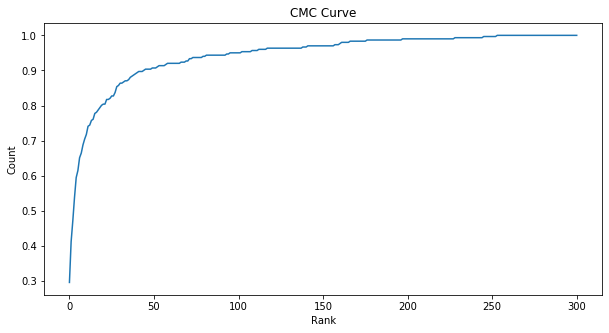

In [44]:
cmc = np.zeros(len(np.unique(probe_ID)))
for i in range(len(np.unique(probe_ID))):
    cmc[i] = np.sum(ranked_histogram[:(i + 1)])
    
print(cmc)

fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(1, 1, 1)
ax.plot(cmc/len(np.unique(probe_ID)))
ax.set_xlabel('Rank')
ax.set_ylabel('Count')
ax.set_title('CMC Curve');

In [45]:
# Final Results
rank_accuracy = cmc/len(np.unique(probe_ID))
print('Accuracy for Rank-1  retrieval: %f%%' % (rank_accuracy[0]*100))
print('Accuracy for Rank-5  retrieval: %f%%' % (rank_accuracy[4]*100))
print('Accuracy for Rank-10 retrieval: %f%%' % (rank_accuracy[9]*100))

Accuracy for Rank-1  retrieval: 29.568106%
Accuracy for Rank-5  retrieval: 59.468439%
Accuracy for Rank-10 retrieval: 70.431894%
